# Importing libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

# Read data and Feature extaction

In [6]:
# Define the file path
file_path = r"C:\\Users\\asus2022\\OneDrive - New Ismailia National University\\Documents\\drasa\\GAM3A\\Level3 eng\\SECOND TERM\\KNowldge\\Data\\traffic.csv"

# Check if the file exists, raise an error if not
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Read the CSV file, parse the "DateTime" column as datetime objects
df = pd.read_csv(file_path, parse_dates=["DateTime"])

# Process the time-related data by extracting year, month, day, and hour
df["Year"] = df["DateTime"].dt.year
df["Month"] = df["DateTime"].dt.month
df["Day"] = df["DateTime"].dt.day
df["Hour"] = df["DateTime"].dt.hour

# Drop the "ID" column if it exists
if 'ID' in df.columns:
    df.drop('ID', axis=1, inplace=True)


# Graph 

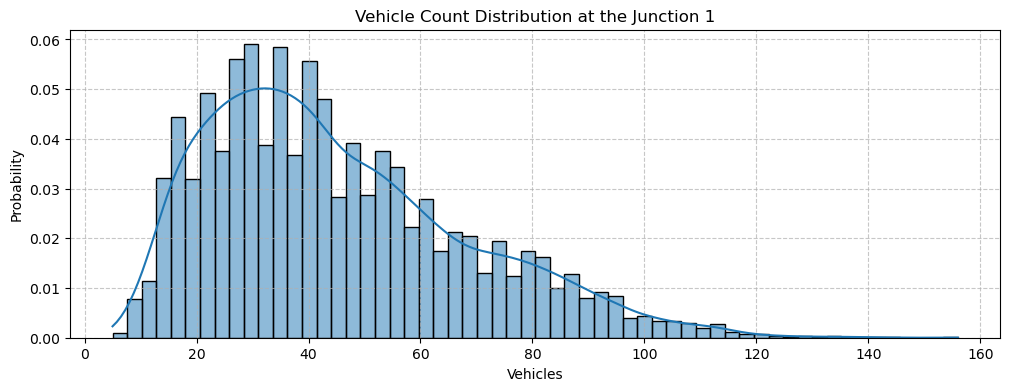

In [24]:
# Function to plot the distribution of vehicle counts at a specific junction
def plot_distribution(junction_id):
    data = df[df['Junction'] == junction_id]
    plt.figure(figsize=(12, 4))
    sns.histplot(data['Vehicles'], kde=True, stat='probability')
    plt.title(f"Vehicle Count Distribution at the Junction {junction_id}")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

junction_id=1
plot_distribution(junction_id)

# split the DataFrame

In [10]:
def split_by_junction(df):
    return [df[df["Junction"] == i].drop("Junction", axis=1) for i in range(1, 5)]

junction_data = split_by_junction(df)

# Data Preprocessing for Junction 1

In [12]:
# Process the data for Junction 1
data_j1 = junction_data[0][["Vehicles", "Year", "Month", "Day", "Hour"]].copy()

# Standardize all features using StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_j1.values)

# Function to create time series sequences for model input
def create_sequences(data, window_size=24):
    X, y = [], []
    # Loop through the data to create sequences with the specified window size
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])  # Append a sequence of data points (features)
        y.append(data[i+window_size][0])  # Append the target value (number of vehicles)
    return np.array(X), np.array(y)

# Create sequences from the scaled data with a window size of 24 hours
X, y = create_sequences(data_scaled, window_size=24)

# Reshape X to be compatible with LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))


In [14]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


# Buuild Model

In [16]:
# GRU 
model = Sequential([
    GRU(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])


C:\Users\asus2022\OneDrive - New Ismailia National University\Documents\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Early stoping for Over fitting  
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stop]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,921 (23.13 KB)

 Trainable params: 5,921 (23.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2074 - mae: 0.3232 - val_loss: 0.1192 - val_mae: 0.2456
Epoch 2/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0568 - mae: 0.1744 - val_loss: 0.0788 - val_mae: 0.2081
Epoch 3/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0556 - mae: 0.1716 - val_loss: 0.0777 - val_mae: 0.2048
Epoch 4/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0472 - mae: 0.1630 - val_loss: 0.0731 - val_mae: 0.1961
Epoch 5/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0504 - mae: 0.1631 - val_loss: 0.0755 - val_mae: 0.2021
Epoch 6/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0481 - mae: 0.1597 - val_loss: 0.0690 - val_mae: 0.1960
Epoch 7/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0468 - mae: 0.1576 - val_loss: 0.0705 - val_mae: 0.2027
Epoch 8/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0451 - mae: 0.1539 - val_loss: 0.0666 - val_mae: 0.1932
Epoch 9/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

In [20]:
# Save model
model.save("Traffic_Prediction.h5")


In [21]:
# Load model 
model1 = load_model("Traffic_Prediction.h5", compile=False)

In [25]:
# التنبؤ وعرض النتائج
y_pred = model.predict(X_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


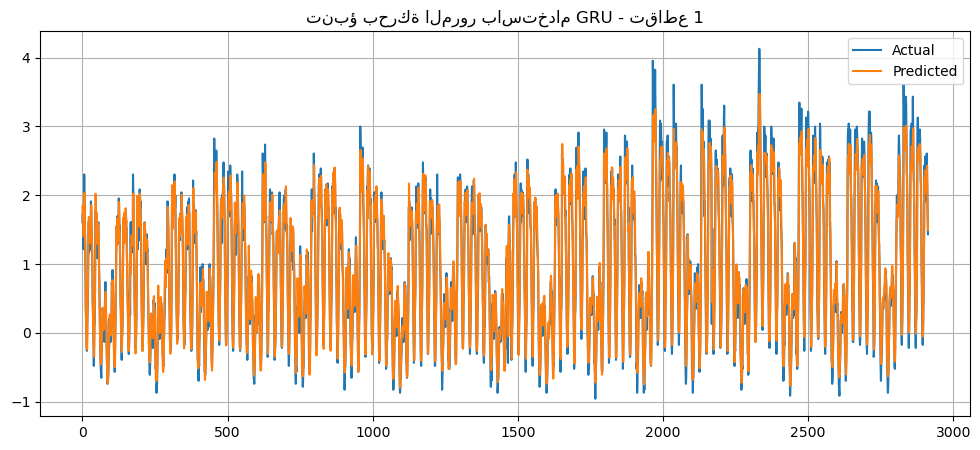

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("تنبؤ بحركة المرور باستخدام GRU - تقاطع 1")
plt.grid(True)
plt.show()